# INPE Downloader

## Custom Parsers

This package can be used to download files from different services or other data that is not currently available in the original implementation. For that, let's take a look on how to create a custom parser for a data that is available in INPE's FTP but not yet implemented. The `MONTHLY_AVERAGE` data.

http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_AVERAGE/

In [1]:
# initial imports
%load_ext autoreload
%autoreload 2

from datetime import datetime

import geopandas as gpd
import xarray as xr
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import INPEParsers, INPETypes
from mergedownloader.parser import BaseParser
from mergedownloader.utils import DateFrequency, DateProcessor


### What does a Parser do?

The parser is responsible for ultimately downloading the desired file. The `BaseParser`class will do that for us. The most important is to tell the Parser how to get to the file and what type is the data. So, when instanciating a new `BaseParser` instance we will have to provide the following:

In [2]:
BaseParser?

Init signature:
BaseParser(
    datatype: Union[enum.Enum, str],
    root: str,
    filename_fn: Callable,
    foldername_fn: Optional[Callable] = None,
    date_freq: mergedownloader.enums.DateFrequency = <DateFrequency.DAILY: {'days': 1}>,
    ftp: Optional[mergedownloader.utils.FTPUtil] = None,
    avoid_update: bool = True,
    post_proc: Optional[Callable] = None,
    mirror_folder: bool = False,
)
Docstring:     
This class implements a Base Parser that is responsible for getting to the
desired file and downloading it. For that, we should provide:

datatype: To which type this data refers to. This can be a string (e.g., 'MonthlyAverage')
root: The root folder in the FTP that stores this data (e.g., /modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_AVERAGE/)
fn_creator: This is the FileName creator. This function is responsible for getting a datetime
            and providing the target filename, for example: MERGE_CPTEC_mean_apr.nc
fl_creator: This is the Folder creator. This funciton

### Create a Custom Parser

In [3]:
### Let's create the basic variables
# For datatype we can pass a string
datatype = 'MonthlyAverage'

# The root is just the folder where the data is located
root = '/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_AVERAGE'

# In the case of MonthlyAverage, the date_freq is Monthly
# The date frequency is important to download a sequence of files
date_freq = DateFrequency.MONTHLY

# As all the files are in the same `MONTHLY_AVERAGE` folder, we can ignore fl_creator
fl_creator = None



Now, we have to define the most important function that is the fl_creator. This function will be responsible for getting a date (`datetime`) and parsing it to create the target filename. Let's take a look how it should be implemented. 

<b>Note:</b>The DateProcessor has several helper functions to achieve the desired result. 

In [4]:
def monthly_average_filename(date: datetime):
    """Create the filename for the monthly average data. E.g.,MERGE_CPTEC_mean_apr.nc"""

    month_abrev = DateProcessor.month_abrev(date)
    return f"MERGE_CPTEC_mean_{month_abrev}.nc"

# let's test it
monthly_average_filename(datetime(2022, 1, 1))

'MERGE_CPTEC_mean_jan.nc'

In [6]:
# we will pass this function to the fn_creator variable
fn_creator = monthly_average_filename

# and create the parser
monthly_average_parser = BaseParser(
    datatype=datatype,
    root=root,
    date_freq=date_freq,
    filename_fn=fn_creator
)

### Testing the custom Parser

In [7]:
monthly_average_parser.remote_target('2000-01')

'/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_AVERAGE/MERGE_CPTEC_mean_jan.nc'

In [8]:
# create a downloader with this parser
downloader = Downloader(
    server=INPEParsers.FTPurl, 
    parsers=[monthly_average_parser],
    local_folder='../tmp',
)

In [9]:
downloader.data_types

['MonthlyAverage']

In [10]:
# Get the MONTHLY_AVERAGE for December
file = downloader.get_file('2000-12', datatype='MonthlyAverage')
file

PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_dec.nc')

In [11]:
# download the full series from january to dec
files = downloader.get_range('2000-01', '2000-12', datatype='MonthlyAverage')
files

[PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_jan.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_feb.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_mar.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_apr.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_may.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_jun.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_jul.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_aug.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_sep.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_oct.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_nov.nc'),
 PosixPath('../tmp/MonthlyAverage/MERGE_CPTEC_mean_dec.nc')]

### Create the Cube and Time Series

In [12]:
cube = downloader.create_cube('2000-01', '2000-12', datatype='MonthlyAverage')
cube

<xarray.DataArray (variable: 1, time: 12, lat: 691, lon: 474)>
array([[[[ 4.421646  ,  4.3804984 ,  4.375     , ...,  3.25614   ,
           3.26228   ,  3.2849157 ],
         [ 4.405059  ,  4.366569  ,  4.364461  , ...,  3.16908   ,
           3.174212  ,  3.182368  ],
         [ 4.4440985 ,  4.407808  ,  4.366569  , ...,  3.0845857 ,
           3.0846775 ,  3.0959494 ],
         ...,
         [ 2.8190982 ,  2.5667155 ,  2.2739186 , ...,  0.6670638 ,
           0.8289956 ,  0.79224706],
         [ 2.6487353 ,  2.4727824 ,  2.225715  , ...,  0.64855206,
           0.6513013 ,  0.74862534],
         [ 2.7035375 ,  2.5270345 ,  2.3422837 , ...,  0.65249264,
           0.642412  ,  0.6096041 ]],

        [[ 5.4908476 ,  5.4858303 ,  5.4158225 , ...,  3.4300268 ,
           3.4094408 ,  3.4141114 ],
         [ 5.470146  ,  5.431864  ,  5.432609  , ...,  3.4178586 ,
           3.3856359 ,  3.4261258 ],
         [ 5.45817   ,  5.4099307 ,  5.3834424 , ...,  3.4128275 ,
           3.4500113 ,  3.470041  ],
...
         [10.520019  , 10.757518  , 10.615942  , ...,  1.8990942 ,
           1.9986413 ,  1.9286232 ],
         [10.591395  , 10.476902  , 10.069746  , ...,  1.9397645 ,
           1.9618659 ,  1.8936595 ],
         [10.641576  , 10.143478  ,  9.890308  , ...,  1.8705616 ,
           2.024819  ,  1.7977355 ]],

        [[ 4.4020863 ,  4.312938  ,  4.301017  , ...,  1.8806977 ,
           1.8797336 ,  1.9009467 ],
         [ 4.4387274 ,  4.3830647 ,  4.340375  , ...,  1.8944601 ,
           1.9158485 ,  1.94723   ],
         [ 4.490971  ,  4.4517007 ,  4.409362  , ...,  1.9466164 ,
           1.9470547 ,  2.013061  ],
         ...,
         [ 4.8789444 ,  4.6072054 ,  4.3413396 , ...,  1.3430926 ,
           1.3423036 ,  1.4207574 ],
         [ 5.019197  ,  4.6681275 ,  4.2386923 , ...,  1.3602735 ,
           1.3078542 ,  1.3415147 ],
         [ 5.3110976 ,  4.945214  ,  4.421371  , ...,  1.3290673 ,
           1.3356416 ,  1.3031206 ]]]], dtype=float32)
Coordinates:
  * lon       (lon) float64 -81.95 -81.85 -81.75 -81.65 ... -34.85 -34.75 -34.65
  * lat       (lat) float64 -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time      (time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-12-01T12:00:00
  * variable  (variable) object 'precmed'

In [14]:
# as the variable is precmed, let's get this variable and calculate the mean over time
ts = cube.mean(dim=['lat', 'lon'])

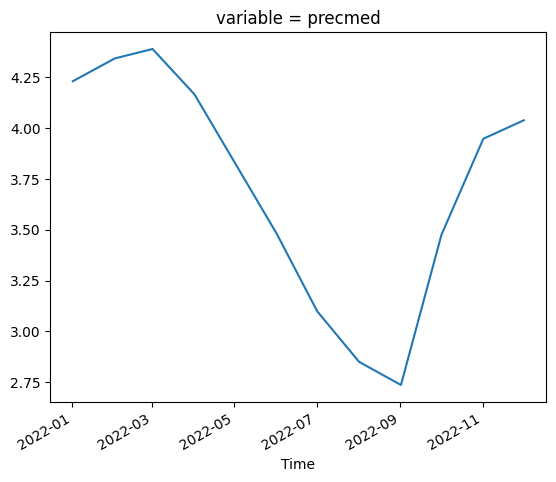

In [15]:
ts.plot()